# Data For Good Technical Walkthrough

**Objective:** exploring Kaggle survey respondants to understand the technical and other differentiations between the Data Scientist, Data Analyst, Data Engineer and Developer role. 

**Biases:** When performing this analysis or when leveraging this data to make decisions, we should keep in mind the inherent biases found in our data. All of our survey respondants are Kaggle users with an interest in machine learning. They are certainly not representative of the industry in general.

In [14]:
import pandas as pd 
import plotly as py
import seaborn as sns 
import matplotlib.pyplot as plt

# get current directory
dir_path = os.path.dirname(os.path.realpath("__file__"))

# Read in data 
data = pd.read_csv(dir_path + "/multipleChoiceResponses.csv", low_memory = False)

# Extract column names 
colnames = data.iloc[0,:]

data = data.iloc[1:,:]

# set seaborn style 
sns.set(style="whitegrid")

## Outlier Removal 

Outerliers can be due to: 
1. Errorenous input (someone deliberately/accidentally lied on the survey) 
2. Extreme examples (think the "Wayne Gretzsky" of data science)

In [2]:
""" Removing Potentially Erroraneous input """

# Remove responses that are completed under 30 seconds
# These respondants likely rushed through the survey without much thought (responses won't be as credible)
data["Time from Start to Finish (seconds)"] = data["Time from Start to Finish (seconds)"].apply(pd.to_numeric)
data = data[data["Time from Start to Finish (seconds)"] > 30]

# Remove logical inconsistencies
# Example: Remove respondants who claim to be unemployed and making more than a certain amount of money
# No cases in this dataset

# We are interested in other a subset of careers
def change_title(title):
    if title in ['Consultant','Research Assistant','Research Scientist','Statistician', 'Data Journalist', 'Principal Investigator']:
        title = 'Other'
    elif title in ['Software Engineer','Developer Advocate', 'DBA/Database Engineer']:
        title = 'Developer'
    elif title in ['Marketing Analyst', 'Salesperson', 'Product/Project Manager', 'Business Analyst']:
        title = 'Business Role'
    return title

data["Q6"] = data["Q6"].apply(change_title)

## Where do surveyors come from?

Plotting surveyor location on chlorepath map.

In [3]:
country_freq = data["Q3"].value_counts().reset_index()
country_freq.columns = ["country", "num respondants"]

# Obtain country codes for plotting 
# Note: examining the data tells us that not all countries are properly coded
# We can create a mapper to map names as they appear in the survey to the country names in the plotly dataset

mapper = {"United States of America": "United States",
          "Viet Nam": "Vietnam",
          "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
          "South Korea": "Korea, South",
          "Iran, Islamic Republic of...": "Iran",
          "Hong Kong (S.A.R.)": "Hong Kong",
          "Republic of Korea": "Korea, North"
         }

country_freq["country"] = country_freq["country"].apply(lambda x: mapper[x] if x in mapper.keys() else x)

codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')

# Merge country codes with country names 
country_freq = pd.merge(country_freq, codes, how = "inner", left_on = ['country'], right_on = ['COUNTRY'])

# Plot respondants by country
api_key = "Redacted"
py.tools.set_credentials_file(username='happilyeverafter95',api_key=api_key)

country_plot = [ dict(
        type = 'choropleth',
        locations = country_freq['CODE'],
        z = country_freq["num respondants"],
        text = country_freq['COUNTRY'],
        colorscale = "Greens",
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Number of Responders'),
      ) ]

layout = dict(
    title = 'Responders by country',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

# See plot at https://plot.ly/~happilyeverafter95/0
fig = dict( data=country_plot, layout=layout )
py.plotly.iplot(fig, validate=False, filename='d3-world-map')


PlotlyRequestError: Aw, snap! You tried to use our API as the user 'happilyeverafter95', but the supplied API key doesn't match our records. You can view your API key at https://plot.ly/settings/api

You're most likely getting this message because your local credentials file isn't synced with the Plotly server you're communicating with.

Go to https://plot.ly/<language>/getting-started (e.g., https://plot.ly/python/getting-started) for more information.

Make sure that you're logged in as happilyeverafter95.

Need help? Please try searching Plotly's <a href='http://stackoverflow.com/questions/tagged/plotly'>Stack Overflow channel</a>.

## Level of Education for each Job

How "educated" do you need to be to be a data scientist? Data Engineer? Data Analyst?

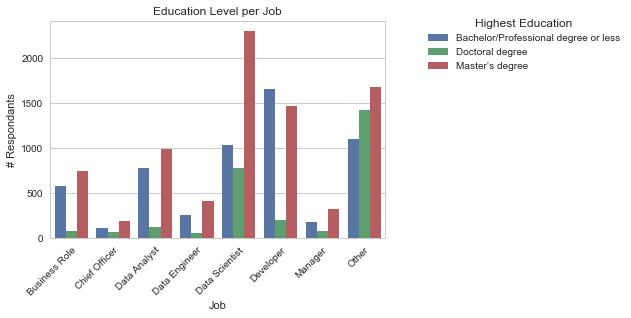

In [5]:
education = data[["Q4", "Q6"]].dropna(how = "any")
education.columns = ["education", "job"]

# Remove responses from students, unemployed individuals or people who chose not to answer
education = education[~education["job"].isin(["Student", "Not employed", "I prefer not to answer"])]
education = education[education["education"] != "I prefer not to answer"]

# Separate into Master's, Doctoral, Bachelor's/Professional degree or less 
education["education"] = education["education"].apply(lambda x: x if x in ["Doctoral degree", "Master’s degree"] else "Bachelor/Professional degree or less")

education = education.groupby(["job", "education"]).size().reset_index()
education.columns = ["job", "education", "Num"]

ax = sns.barplot(x="job", y="Num", hue = "education",data=education)
ax.set(xlabel = "Job", ylabel = "# Respondants")

# Setting title 
ax.set_title("Education Level per Job")

# Making sure that legend does not block plot 
ax.legend(bbox_to_anchor=(1.1, 1.05), title = "Highest Education")

# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')

plt.show()

## Salary Variations between Jobs 

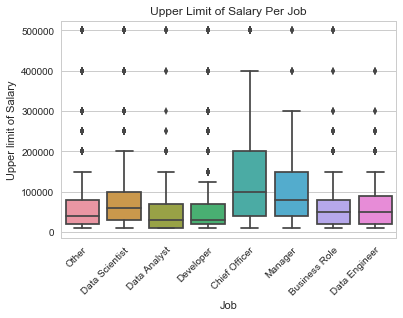

In [6]:
salary = data[["Q6", "Q9"]].dropna(how = "any")
salary.columns = ["job", "salary"]

# Remove respondants who are students, unemployed or wish not to disclose yearly compensation
salary = salary[~salary["job"].isin(["Student", "Not employed","I prefer not to answer"])]
salary = salary[salary["salary"] != "I do not wish to disclose my approximate yearly compensation"]

# Map salary to upper limit
def map_salary(amt):
    amt = amt.split("-")
    if len(amt) == 2:
        amt = amt[1]
    else: 
        amt = amt[0]
    amt = [c for c in amt if c.isdigit()]
    amt = "".join(amt)
    return int(amt)

salary["salary"] = salary["salary"].apply(map_salary)

ax = sns.boxplot(x="job", y = "salary",data=salary)

# Setting title 
ax.set_title("Upper Limit of Salary Per Job")

ax.set(xlabel = "Job", ylabel = "Upper limit of Salary")

# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')

plt.show()

The range is very large for the previous salary chart. 

Let's remove some superstar observations and see if that gives us more insight.

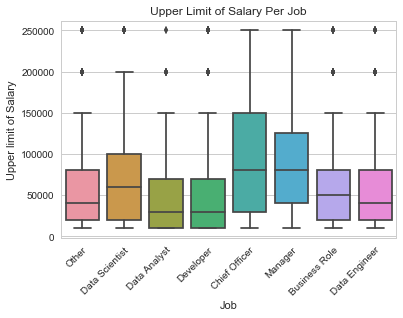

In [7]:
# Remove all responses where upper limit of salary > (mean + 3 standard deviation)

mean = salary["salary"].mean()
std = salary["salary"].std()

salary = salary[salary["salary"] <= mean + 3*std]

ax = sns.boxplot(x="job", y = "salary",data=salary)
ax.set(xlabel = "Job", ylabel = "Upper limit of Salary")

# Setting title 
ax.set_title("Upper Limit of Salary Per Job")

# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')

plt.show()

## Career Distribution by Gender

What are the most popular careers amongst female Kagglers, male Kagglers?

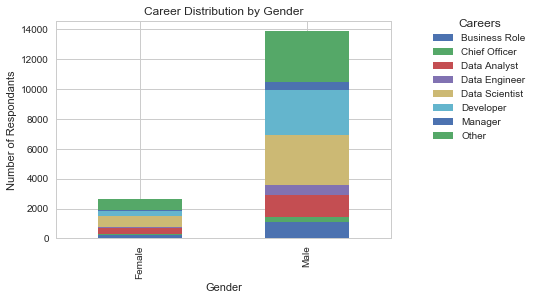

In [8]:
gender = data[["Q6", "Q1"]].dropna(how = "any")
gender.columns = ["job", "gender"]

# Remove responses from students, unemployed individuals and those who do not wish to describe/disclose their gender
gender = gender[~gender["job"].isin(["Student", "Not employed", "I prefer not to answer"])]
gender = gender[~gender["gender"].isin(["Prefer not to say", "Prefer to self-describe"])]

# Prepare dataframe for a stacked bar graph
gender = gender.groupby(["job", "gender"]).size().reset_index().pivot(columns = "gender", index = "job")[0]

ax = gender.T.plot(kind='bar', stacked=True)

ax.set(xlabel = "Gender", ylabel = "Number of Respondants")

# Setting title 
ax.set_title("Career Distribution by Gender")

ax.legend(bbox_to_anchor=(1.1, 1.05), title = "Careers")

plt.show()

## Majors to Careers

What types of majors lead to what types of careers?

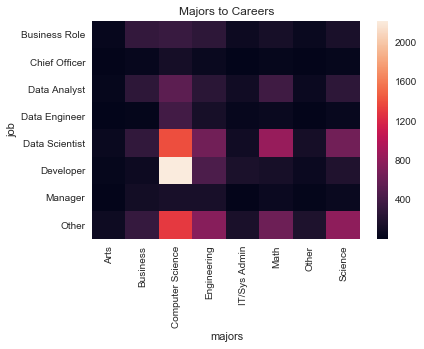

In [9]:
majors = data[["Q6", "Q5"]].dropna(how = "any")
majors.columns = ["job", "majors"]

# Rewording/Grouping Major titles
major_map = {"A business discipline (accounting, economics, finance, etc.)": "Business",
              "Computer science (software engineering, etc.)": "Computer Science", 
              "Engineering (non-computer focused)": "Engineering",
              "Environmental science or geology": "Science",
              "Fine arts or performing arts": "Arts",
              "Humanities (history, literature, philosophy, etc.)": "Arts",
              "I never declared a major": "Other",
              "Information technology, networking, or system administration": "IT/Sys Admin",
              "Mathematics or statistics": "Math",
              "Medical or life sciences (biology, chemistry, medicine, etc.)": "Science",
              "Other": "Other",
              "Physics or astronomy": "Science",
              "Social sciences (anthropology, psychology, sociology, etc.)": "Science"}
    
majors["majors"] = majors["majors"].apply(lambda x: major_map[x])
    
# Remove responses from students, unemployed individuals and those who do not wish to describe/disclose their gender
majors = majors[~majors["job"].isin(["Student", "Not employed", "I prefer not to answer"])]

# Prepare dataframe for heatmap
majors = majors.groupby(["job", "majors"]).size().reset_index().pivot(columns = "majors", index = "job")[0]

ax = sns.heatmap(majors)

ax.set_title("Majors to Careers")

plt.show()
